<a href="https://colab.research.google.com/github/Swamp-Solutions/Litter-buster/blob/dev-aendraes/Notebooks/Email_client.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Construct Email-client
We want to have an email client to alert us if our model detects any litterers. 

---
---



### 1. Imports

In [13]:
from email.mime import multipart 
import os 
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email.mime.image import MIMEImage # to accomodate image attachment
from email import encoders
import torch
from datetime import datetime as dt, timedelta as td
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Initialize working environment
Create the folder and file structure that is necessary for the functions.

In [2]:
def initialize():
  if not os.path.exists('./Images'):
    os.makedirs('./Images/originals')
    os.makedirs('./Images/results')
  if not os.path.exists('./Images/results/log.txt'):
    with open('./Images/results/log.txt', 'w') as f: f.write('')
  return False
initialize()

False

### 2. Mail client
Basically a simple email smtp python-client.  \
Customized from this [Medium Article](https://vigneshkathirkamar.medium.com/send-image-notification-on-person-detection-using-opencv-and-python-460ba6f97e7b).

In [3]:
def send_mail(uname,pwd,text="Culprit detected!!", subject="Capture",from_email= None,to_emails=None, html=None,attachment=None,):
    assert isinstance(to_emails, list)
    msg = MIMEMultipart()
    msg['From'] = str(from_email)
    msg['To'] = ", ".join(str(to_emails))
    msg['Subject'] = subject

    # reading the image
    with open(attachment, 'rb') as f:
        img_data = f.read()

    txt_part = MIMEText(text, 'plain')
    msg.attach(txt_part)
    image = MIMEImage(img_data, name=os.path.basename(attachment)) 
    msg.attach(image)
    msg_str = msg.as_string()
    
    # server side coding
    server = smtplib.SMTP(host='smtp.gmail.com',port=587)
    server.ehlo()
    server.starttls()
    server.login(uname, pwd)
    server.sendmail(from_email,list(to_emails),msg_str)
    server.quit() # quits the server

# send_mail("aendraes@gmail.com","hutwnwiqwukfrspz",to_emails=['aendraes@gmail.com', 'helenalbandak@gmail.com', 'mcvk1991@gmail.com'],from_email='aendraes@gmail.com', attachment="square-square-in-a-square.jpg") #note that we need pass the mail as a list data type



### 3. Create a model predict/email function.
We need something that takes as input an image, tests it against the model, checks if there are any results and if there are, save the file, and runs the email client with the picture as an attachement. \
We may additionally want to store a logfile to set a time limit between mails in the case of video capture. \
For a cleaner look I'll just create a function to handle the timestamps too.

#### Timestamps:
The purpose of this function is to handle a logfile of timestamps to allow for consistently checking the model without spamming someone's mail. \
The function _**gettime**_ takes two arguments, getter and **kwargs for the timedelta td. (hours, minutes, days, years and so on.) \
**getter** is a boolean value, set to True as standard. If the function is called as a "getter" it will read the last value from the logfile and check it against the current time. \
If the function is called as a "setter"(getter=False), it will append the current time to the logfile.

Note: The use of a logfile may be changed in the future as it is not optimal for speed, depending on what the main functionality of the program will be like.

In [4]:

def gettime(getter=True, **kwargs):
  if getter:
    with open("./Images/results/log.txt", 'r') as f:

      if latest:=f.readlines():
        latest=latest[-1] 
        if dt.strptime(latest.strip(), "%m-%d-%Y-%H-%M-%S") <= dt.now() - td(**kwargs): 
          return True
        else:
          return False
      return True
  if not getter:
    with open("./Images/results/log.txt", "a") as f:
      f.write(dt.now().strftime("%m-%d-%Y-%H-%M-%S")+'\n')
      return False

#### Check model and Send mail
We allow both images and image objects into the function, but to make sure there is no differentiation in functionality we load the image into the model as an image-object. \
Run image through the model. Check if there are results and if there are, save the image by time and send it to assigned e-mail addresses. \
For the image to be interpreted as an image we use numpy.squeeze on results.render() which returns a matrix.

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-2-7 Python-3.8.10 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 7053277 parameters, 0 gradients
Adding AutoShape... 


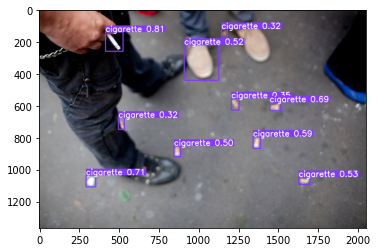

In [15]:

def check_model_send_mail(model, imgpath='', img=None):
  if imgpath and not img:
    img = Image.open(imgpath)
  results = model(img)
  if results and gettime(hours=4):
    plt.imshow(np.squeeze(results.render()))
    img = Image.fromarray(np.squeeze(results.render()))
    fpath = './Images/results/' + dt.now().strftime("%m-%d-%Y-%H-%M-%S")+'.jpg'
    img.save(fpath)
    gettime(False)
    send_mail("aendraes@gmail.com","hutwnwiqwukfrspz",to_emails=['aendraes@gmail.com'],from_email='aendraes@gmail.com', attachment=fpath, text=dt.now().strftime("%m-%d-%Y-%H-%M-%S"), subject="Litter-Buster Alert!")
  return None
model = torch.hub.load('ultralytics/yolov5', 'custom', path='best.pt', force_reload=True)
check_model_send_mail(model,'smokers.jpg')